# Intro to Keras

In the following, we will be introduced to the [Keras Deep Learning Library](https://keras.io/). The library is a high-level API to get you started with building your own neural networks! In this tutorial, we'll be building a feed-forward neural network, and in the next assignment you'll build different CNN architectures.

The essence of Keras revolves around different Keras **models**. The simplest type of model is the ```Sequential``` model, a **linear** stack of layers. For more complex architectures, you should use the [Keras functional API](https://keras.io/getting-started/functional-api-guide/), which allows to build arbitrary graphs of layers.

Below are a few of the key commands to get you started right away!

To get rid of some warning logs, you can run the following helper method:

In [1]:
# Run cell to get rid of some warnings later on

def noWarnings():
    import os
    os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    from tensorflow import logging
    logging.set_verbosity(logging.INFO)

###### 1) Create a Sequential model

In [2]:
from keras.models import Sequential

model = Sequential()

Using TensorFlow backend.


###### Stacking Layers

Stacking layers is as easy as ```.add()```:

Note that for the first layer, we must specify the ```input_dim``` parameter since the first layer of a linearly stacked neural network feeds each input feature to its respective neuron.

You must also specify the number of units per layer, as well as specify an activation function.

###### 2) Add 2 layers to the model.

- an input layer of 64 neurons using the ReLU activation function, with input dimension of 100
- a layer of 10 units with the softmax activation function (output layer)

In [3]:
from keras.layers import Dense

model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


###### 3) Specify the model's learning process

Before training, we have to use the ```.compile()``` method which specifies the model's learning process. To create a learning process, the following parameters need to be specified:

- a loss function, e.g. categorical cross entropy for multiclass classification
- an optimization method, e.g. stochastic gradient descent
- a metric to optimize for, e.g. accuracy for classification

**TIP**: custom loss functions can be daunting (typically specific tasks will have their own custom loss functions), the [Keras Losses Documentation](https://keras.io/losses/) shows a few loss functions available in the API, read up online to see if the loss function is suitable for the task at hand.

In [4]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

If you need to, you can further configure your optimizer!

In [5]:
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))

###### 4) You can now iterate on your training data in batches (following code will not run unless you specify X_train, y_train)

Note the similarity with sklearn's ```.fit()``` command to train a model! Note that the ```epochs``` parameter denotes the number of times the model will pass over the training set during the training phase ([More info here](https://keras.io/getting-started/faq/#what-does-sample-batch-epoch-mean))

```

# X_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(X_train, y_train, epochs=5, batch_size=32)

```

##### 5) Evaluating Model Performance

To evaluate model performance, use the ```.evaluate()``` command:

```

loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)

```

###### 6) ...or make new predictions on test data!

Use the ```.predict()``` command:

```

classes = model.predict(x_test, batch_size=128)

```

#### Building a Deep Neural Network for Multiclass Classification

Let's take a look at a multi-class classification problem, picking 3 classes for demonstration, but our approach generalizes to any number of classes.

To see how deep neural networks are helpful compared to other traditional supervised learning algorithms, we'll be inspecting a dataset that is not linearly separable. We'll then try to solve the problem using **softmax** regression in Keras, which is extremely similar to logistic regression, but is used for multiclass problems.

We'll then attempt to tackle the same problem using a neural network.

###### 1) Import the following libraries for this exercise

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical
from matplotlib.colors import ListedColormap

###### 2) Some helper methods

Here are some helper methods to generate datasets and to help create visually appealing plots.

In [7]:
def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

###### 3) Plot the data generated.

Inspect the shape of X, y.

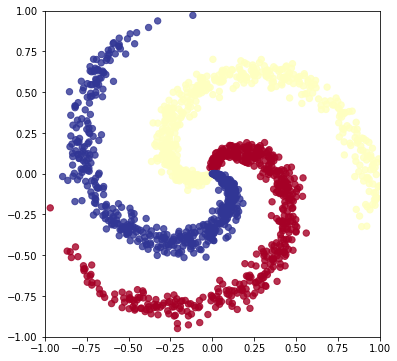

In [8]:
X, y = make_multiclass(K=3)

In [9]:
print(X.shape)
print(y.shape)

(1500, 2)
(1500,)


###### 4) Building a Logistic Regression Model as a Reference to a Softmax Regression Model

Recall the Logistic Regression supervised learning algorithm for binary classification problems. As the problem states, LR works with binary labels 0/1. Softmax Regression (SR) is a generalization of LR where we can have more than 2 classes. In our current dataset we have 3 classes, represented as 0/1/2.

Building the model for SR is very similar to LR, for reference here's how a **LR model** is built:

```

model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=20)

```


###### 5) Building a Softmax Regression Model

The core idea of building the softmax regression model in Keras is very similar to the LR model in the sample code above. Let's go over a few of the differences to consider when implementing SR for multiclass classification:

- **Number of nodes in the dense layer:** LR uses 1 node, while SR uses 3. Since we have 3 classes, it intuitively makes sense for SR to have 3 nodes. Then the question is, why does LR uses only 1 node for 2 classes?

The answer is simply because we can achieve the same result with using only 1 node. Recall from previous lectures, LR models the probability of an example belonging to class one: $P(y=1)$. We know the sum of the probabilities in a probability distribution is always 1, so we can calculate class 0 probability by: $1 - P(y=1)$. But when we have more than 2 classes, we need individual nodes for each class (knowing the probability of one class doesn't let us infer the probability of the other classes).


- **Activation function:** LR used sigmoid activation function, SR uses *softmax*. It scales the probability of the output neurons such that they sum up to 1. So in our case $P(y=0) + P(y=1) + P(y=2) = 1$. For now you can simply think of it as a normalization function which let's us interpret the output values as probabilities.

- **Loss function:** In a binary classification problem like LR, the loss function is binary_crossentropy. In the multiclass case like SR, the loss function is categorical_crossentropy. Going into the theory behind loss functions is beyond the scope of this tutorial.

- **Fitted data:** LR used the vector y directly in the fit function, which has just one column with binary 0/1 values. When we're applying SR the labels need to be in *one-hot* representation. In our case y_cat is a matrix with 3 columns, where all the values are 0 except for the one that represents our class, which is set to 1 instead (Hint: check the imports)


Note: recall that LR is a linear classifier, and so is SR, but for multiple classes. Hence, the "power" of the model hasn't changed, it is simply the multiclass extension of LR.

When trained correctly, the model gives us an accuracy of around 50%, because the dataset is not linearly separable.

**Train an SR model on the dataset generated above.**

In [10]:
noWarnings()
model = Sequential()
model.add(Dense(3, input_shape=(2,), activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=20)

Instructions for updating:
Use tf.cast instead.


###### 6) Plot the loss accuracy, decision boundaries learned by the model

<Figure size 576x432 with 0 Axes>

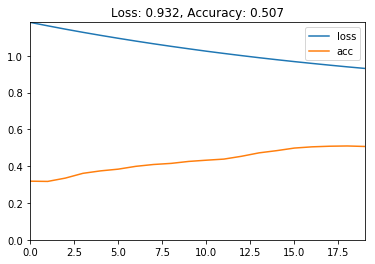

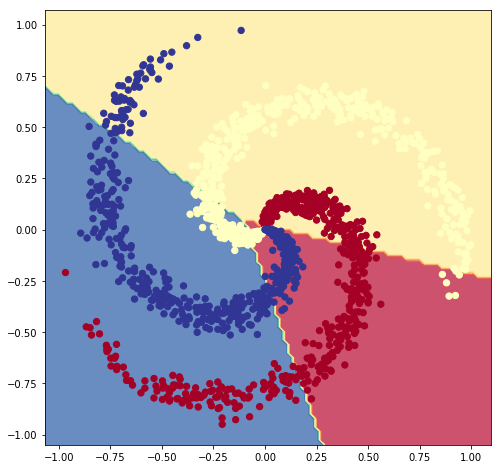

In [11]:
# Plot loss accuracy of your model using the plot_loss_accuracy helper method
plot_loss_accuracy(history)

# Plot decision boundaries learned using the multi_class_decision_boundary helper method
plot_multiclass_decision_boundary(model, X, y)

###### 7) Make predictions on X, then evaluate how the algorithm does using classification metrics

- Use the ```.predict_classes()``` method to generate predictions
- Print out metrics using the ```classification_report``` module
- Print out the confusion matrix of the model using the ```confusion_matrix``` helper method

              precision    recall  f1-score   support

         0.0       0.42      0.31      0.36       500
         1.0       0.55      0.67      0.60       500
         2.0       0.53      0.55      0.54       500

    accuracy                           0.51      1500
   macro avg       0.50      0.51      0.50      1500
weighted avg       0.50      0.51      0.50      1500



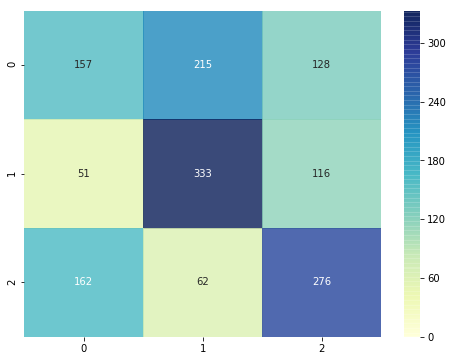

In [12]:
# Evaluate SR performance

y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

### DEEP NEURAL NETWORK

To build a deep neural network, we only need to add more Dense layers. To make learning easier for the network, we'll try adding a couple of Dense layers with tanh activation function, and decrease number of nodes per layer.

To build a more powerful model that can learn non-linearly separable data, we add more layers with non-linear activation functions. Build a classification model in Keras with:

- a densely connected layer with 128 units, 'tanh' activation function
- a densely connected layer with 64 units, 'tanh' activation function
- a densely connected layer with 32 units, 'tanh' activation function
- a densely connected layer with 16 units, 'tanh' activation function
- a densely connected layer with 3 units, 'softmax' activation function

Train your model on the same dataset, defining the learning process similarly to the LR sample code. How many epochs are required to train an accurate model?

###### 8) Build a deep NN model using Keras, fit it on the dataset

In [13]:
# Build a Deep Neural Network model and compile it

model = Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

### YOUR CODE HERE - Fit data on training set

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=True, epochs=50)

Epoch 1/50
1500/1500 [==============================] - 0s 309us/step - loss: 0.8301 - acc: 0.5260
Epoch 2/50
1500/1500 [==============================] - 0s 63us/step - loss: 0.7274 - acc: 0.5660
Epoch 3/50
1500/1500 [==============================] - 0s 60us/step - loss: 0.6570 - acc: 0.6613
Epoch 4/50
1500/1500 [==============================] - 0s 63us/step - loss: 0.5563 - acc: 0.7413
Epoch 5/50
1500/1500 [==============================] - 0s 58us/step - loss: 0.4509 - acc: 0.8353
Epoch 6/50
1500/1500 [==============================] - 0s 56us/step - loss: 0.3430 - acc: 0.9213
Epoch 7/50
1500/1500 [==============================] - 0s 62us/step - loss: 0.2504 - acc: 0.9420
Epoch 8/50
1500/1500 [==============================] - 0s 65us/step - loss: 0.1794 - acc: 0.9687
Epoch 9/50
1500/1500 [==============================] - 0s 73us/step - loss: 0.1284 - acc: 0.9740
Epoch 10/50
1500/1500 [==============================] - 0s 68us/step - loss: 0.0916 - acc: 0.9820
Epoch 11/50
1500/1

###### 9) Plot the loss accuracy, decision boundaries learned by the model

<Figure size 576x432 with 0 Axes>

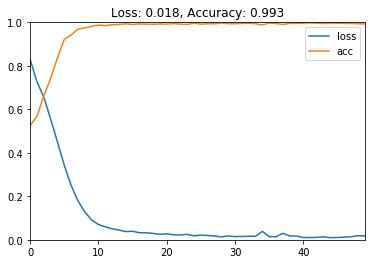

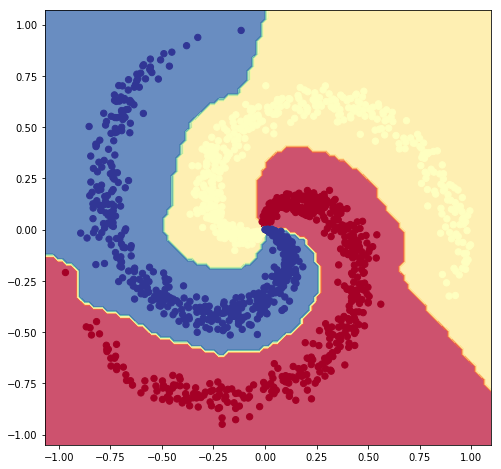

In [14]:
# Plot loss accuracy of your model using the plot_loss_accuracy helper method
plot_loss_accuracy(history)

# Plot decision boundaries learned using the multi_class_decision_boundary helper method
plot_multiclass_decision_boundary(model, X, y)

###### 10) Make predictions on X, then evaluate how the algorithm does using classification metrics

- Use the ```.predict_classes()``` method to generate predictions
- Print out metrics using the ```classification_report``` module
- Print out the confusion matrix of the model using the ```confusion_matrix``` helper method

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       500
         1.0       1.00      1.00      1.00       500
         2.0       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



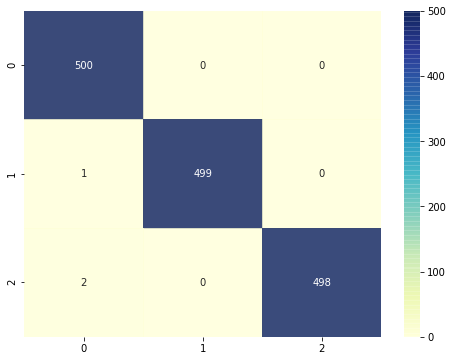

In [15]:
# Evaluate SR performance

y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)